# Face Recognition
- We're going to build a face recognition system.
- Face recognition problem commonly fall into one of two categories :
    1. Face Verificatin : 'Is this the claimed person?' For example, at some airports, we can pass through customs by letting a system scan our passport and then verifying that us (the person carrying the passport) are the correct person. A mobile phone that unlocks using our face is also face verification. This is a 1:1 maching problem.
    2. Face Recognition : 'Who is this person?' For example, the employees entering the office without needing to otherwise identify themselves. This is a 1:K matching problem.
- FaceNet learns a neural network that encodes a face image into a vector of 128 numbers. By comparing 2 such vectors, we can then determine if 2 pictures are of the same person.
- We'll be able to :
    - Differentiate b/w face recognition and face verification.
    - Implement one-shot learning to solve a face recognition problem.
    - Apply the triplet loss functon to learn a network's parameters in the context of face recognition
    - Explain how to pose face recognition as a binary classification problem.
    - Map face images into 128-dimensional encodings using a pretrained model.
    - Perform face verification and face recognition with these encodings.
   
### Channels-last notation :
- We'll be using a pre-trained model which represents ConvNet activations using a 'channels last' convention, as
    - A batch of images will be of shape (m, n_H, n_W, n_C)

# 1. Packages

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import MaxPool2D, AveragePooling2D
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.layers import Lambda, Flatten, Dense
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.layers import Layer
from tensorflow.keras import backend as K
K.set_image_data_format('channels_last')
import os
import numpy as np
from numpy import genfromtxt
import pandas as pd
import tensorflow as tf
import PIL

# 2. Naive Face Verification
- In face verification, we're given 2 images and we have to determine if they are of the same person. The simplest way to do this is to compare the 2 images pixel-by-pixel. If the distance b/w the raw images is below a chosen threshold, it maybe the same person.
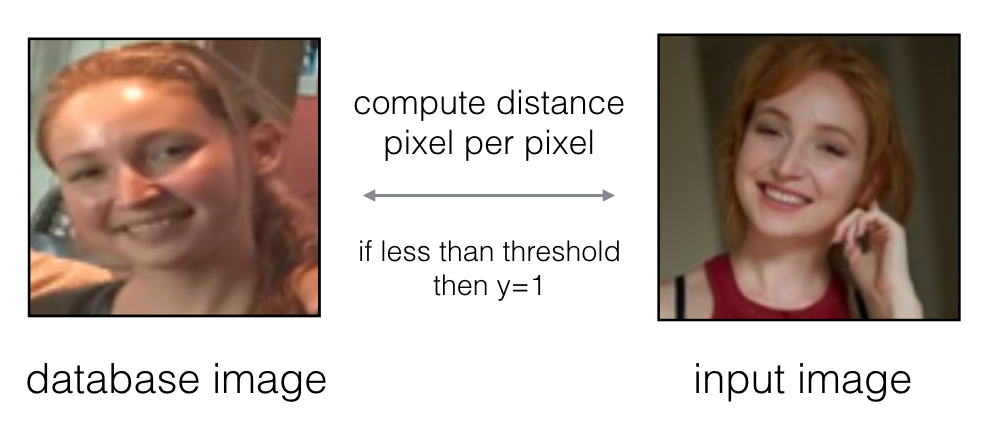
- This algorithm performs poorly, since the pixel values change dramatically due to variations in lighting, orientiation of the person;s face, mior changes in head position and so on.
- Rather than using the raw image, we can learn an encoding f(img)
- By using an encoding for each image, an element-wise comparison produces a more accurate judgment as to whether 2 pictures are of the same person.

# 3. Encoding Face Images into a 128-Dimensional vector
## 3.1 Using a ConvNet to Compute Encodings
- The FaceNet model takes a lot o data and a long time to train. So following the common practice in applied deep learning. We'll load weights that someone else has already trained. The network architecture follows the inception model.
- The key things to be aware of are :
    - This network uses 160x160 dimensional RGB images as its input. Specifically, a face image (or batch of m face images) as a tensor of shape (m, n_H, n_W, n_C) = (m, 160, 160, 3)
- The input images are originally of shape 96x96 thus, we need to scale them to 160x160. This is done in the img_to_encoding() function.
    - The output is a matric of shape (m, 128) that encodes each input face image into 128-dimensional vector.


- By using a 128-neuron fully connected layer as its last layer, the model ensures that the output is an encoding vector of size 1289. We then use the encodings to compare 2 face images as follows
- 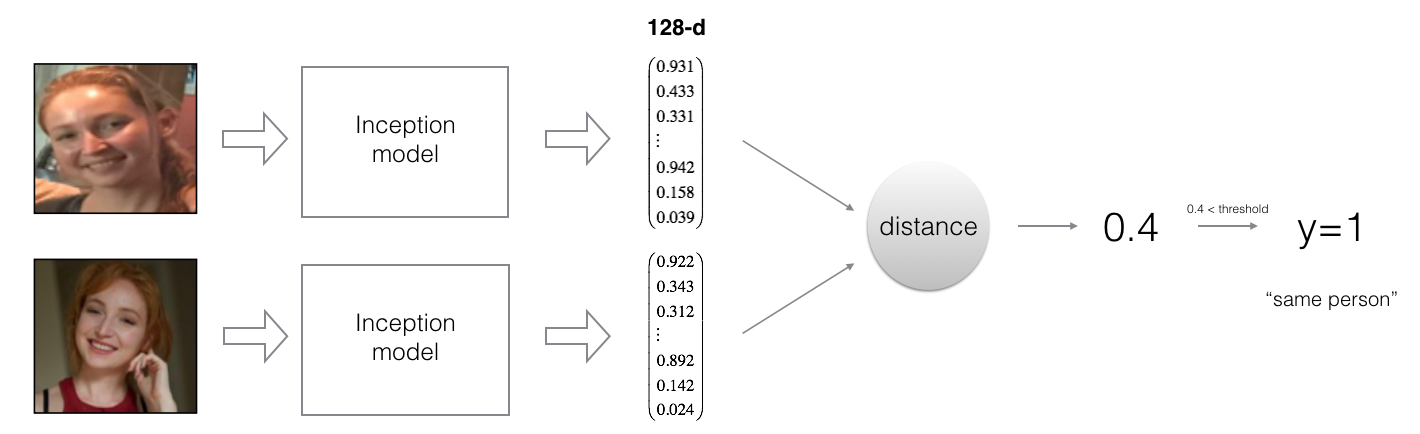
- By computing the distance b/w 2 encodings and thresholding, we can determine if the 2 pictures represent the same person.
- So an encoding is a good one if :
    - The encodings of 2 images of the same person are quite similar to each other.
    - The encodings of 2 images of different persons are very different.
- The triplet loss function formalizes this, and tries to 'push' the encodings of 2 images of the same person (Anchor and Positive) closer together, while 'pulling' the encodings of 2 images of different persons (Anchor, Negative) further apart.
- 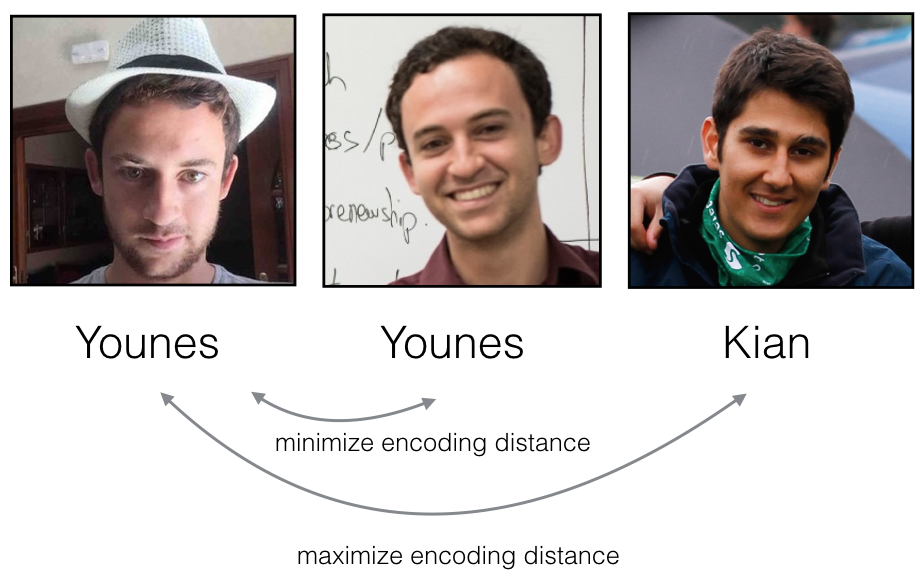

## The Triplet Loss
- The triplet loss is the main ingredient of the face recognition algorithm, and we'll need to know how to use it for training our own FaceNet model. as well as other types of image similarity problems. Therefore, we'll implement it.
- For an image x, its encoding is denoted as f(x), where f is the function computed by the neural network.
    - 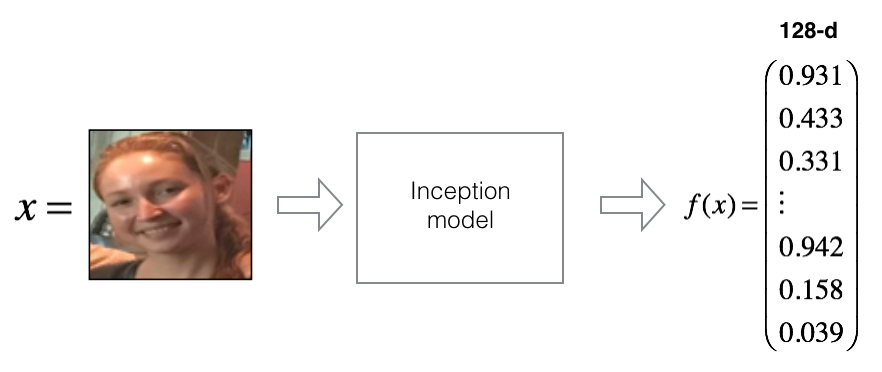
- Training will use triplet of images (A, P, N)
    - A is an 'Anchor' image - a picture of a person
    - P is a 'Positive' image - a picture of the same person as the Anchor image.
    - N is a 'Negative' image -  a picture of a different person than the Anchor image.
- These triplets are picked from the training dataset. (A^(i), P^(i), N^(i)) is used here to denote the ith training example.
- We'd like to make sure that an image A^(i) of an individual is closer to the positive P^(i) than to the Negative image N^(i) by atleast a margin alpha :
    - 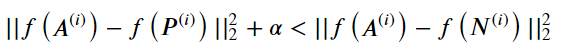
- We would thus like to minimize the following 'triplet cost' :
    - 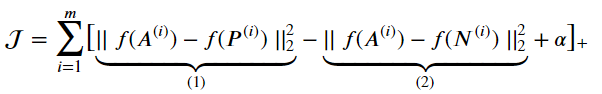
- The notation '[z]+' is used to denote max(z, 0)
- Note :
    - The term (1) is the squared distance b/w the anchor 'A' and the positive 'P' for a given triplet, we want this to be small.
    - The term (2) is the squared distance b/w the anchor 'A' and the negative 'N' for a given triplet, we want this to be relatively large. It has a minus sign preceding it because minimizing the negative of the term is the small as maximining that term.
    - Alpha is called the margin. It's a hyperparameter that we pick manually. We'll use alpha = 0.2

## triplet_loss function 
- Implement the triplet loss as defined by the formula. These are the 4 steps : 
    1. Compute the distance b/w the encodings of 'anchor' and 'positive' : 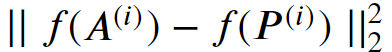
    2. Compute the distance b/w the encodings of 'anchor' and 'negative' : 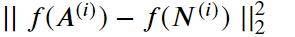
    3. Comput the formula per training example : 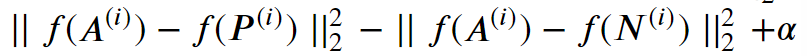
    4. Compute the full formula by taking the max with zero and summing over the training examples : 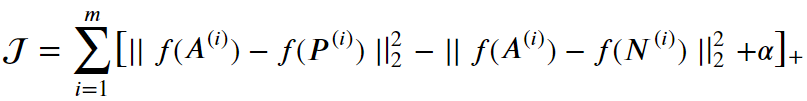

In [1]:
def triplet_loss(y_true, y_pred, alpha = 0.2):
    '''
    Implementation of the triplet loss as defined by formula
    
    Arguments :
    y_true : true labels, required when we define a loss in keras, we don't need it in the function
    y_pred : Python list containing 3 objects:
        anchor : The encodings for the anchor images, of shape (None, 128)
        positive : The encodings for the positive images, of shape (None, 128)
        negative : The encodings for the negative images, of shape (None, 128)
        
    Returns :
    loss : real number, value of the loss
    '''
    
    anchor, positive, negative = y_pred[0], y_pred[1], y_pred[2]
    
    ### START CODE HERE
    # Step 1: Compute the (encoding) distance between the anchor and the positive
    pos_dist = tf.reduce_sum(tf.square(tf.subtract(anchor, positive)), axis=-1)
    # Step 2: Compute the (encoding) distance between the anchor and the negative
    neg_dist = tf.reduce_sum(tf.square(tf.subtract(anchor, negative)), axis=-1)
    # Step 3: subtract the two previous distances and add alpha.
    basic_loss = pos_dist - neg_dist + alpha
    # Step 4: Take the maximum of basic_loss and 0.0. Sum over the training examples.
    loss = tf.reduce_sum(tf.maximum(basic_loss, 0))
    
    return loss

In [5]:
tf.random.set_seed(1)
y_true = (None, None, None) # It is not used
y_pred = (tf.keras.backend.random_normal([3, 128], mean=6, stddev=0.1, seed = 1),
          tf.keras.backend.random_normal([3, 128], mean=1, stddev=1, seed = 1),
          tf.keras.backend.random_normal([3, 128], mean=3, stddev=4, seed = 1))
loss = triplet_loss(y_true, y_pred)
print("loss = " + str(loss))

loss = tf.Tensor(527.2598, shape=(), dtype=float32)


# 4. Loading the Pre-trained Model
- FaceNet is trained by minimizing the triplet loss. But since training requires a lot of data and a lot of computation, we won't train from scratch here. Instead, we'll load a previously trained model.

- Here are some examples of distances b/w the encodings b/w 3 individuals.
- 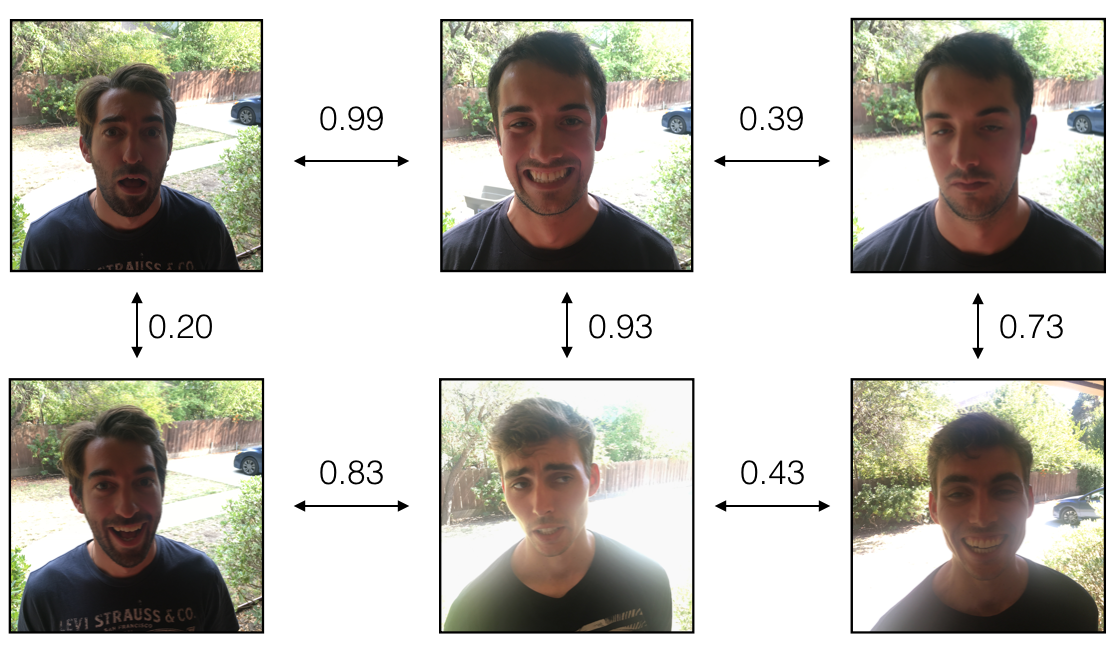

# 5. Applying the Model
- We're building a system for an office building where the building manager would like to offer facial recognition to allow the employees to enter the building.
- We'd like to build a face verification system that gives access to a list of people. To be admitted, each person has to swipe an identification card at the entrance. The face recognition system then verifies that they are who they claim to be.

# 5.1 Face Verification
- Now we'll build a database containing one encoding vector for each person who is allowed to enter the office. To generate the encoding. we'll use img_to_encoding(image_path, model), which runs the forward propagation of the model on the specified image.

- When someone shows up at our front door and swipes their ID card (thus giving us their name), we can look up their encoding in the database, and use it to check if the person standing at the front door matches the name on the ID.

## Verify function
- The verify() function, which checks if the front door camera picture (image_path) is actually the person called 'identity'. We will have to go through the following steps : 
    - Compute the encoding of the image from image_path
    - compute the distance b/w this encoding and the encoding of the identity image stored in the database.
    - Open the door if the distance is less than 0.7, else do not open it.

In [6]:
def verify(image_path, identiy, database, model):
    '''
    Function that verifies if the person on the 'image_path' image is 'identity'
    
    Arguments :
        image_path : Path to an image
        identity : String, name of the person, we'd like to verify the identity, has to be an employee who works in the office.
        database : Python dictionary mapping names of allowed people's name (strings) to their encodings (vectors).
        model : Our inception model instance in keras
        
    Returns :
        dist : Distance b/w the image_path and the image of 'identity' in the database
        door_open : True, if the door should open, False otherwise.
    '''
    # Step 1: Compute the encoding for the image. Use img_to_encoding() see example above. (≈ 1 line)
    encoding = img_to_encoding(image_path, model)
    # Step 2: Compute distance with identity's image (≈ 1 line)
    dist = np.linalg.norm(encoding - database[identity])
    # Step 3: Open the door if dist < 0.7, else don't open (≈ 3 lines)
    if dist < 0.7:
        print("It's " + str(identity) + ", welcome in!")
        door_open = True
    else:
        print("It's not " + str(identity) + ", please go away")
        door_open = False
        
    return dist, door_open

## 5.2 Face Recognition
- Our face verification system is mostly working. But if 'A' person got his ID stolen, when he came back to the office the next data he count't get in.
- To solve this, we'd like to change our face verification system to a face recognition system. This way, no one has to carry an ID card anymore. An authorized person can just walk up to the building, and the door will unlock for them.
- We'll implement a face recognition system that takes as input an image, and figure out if it is one of the authorized persons (and if so, who). Unlike the previous face verification system, we will no longer get a persons's name as one of the inputs.

## who_is_it() function
- Implement who_is_it() with the following steps :
    - Compute the target encoding of the image from image_path
    - Find the encoding from the database that has the smallest distance with the target encoding.
    - Initialize the min_dist variable to a large enough number (100). This helps us keep track of the closes encoding to the input's encoding
    - Loop over the database dictionary's names and encodings. To loop use for (name, db_enc) in database.items()
    - Compute the L2 distance b/w the target 'encoding' and the current 'encoding' from the database. If this distance is less than the min_dist, then set min_dist to dist, and identity to name.

In [7]:
def who_is_it(image_path, database, model):
    """
    Implements face recognition for the office by finding who is the person on the image_path image.
    
    Arguments:
        image_path -- path to an image
        database -- database containing image encodings along with the name of the person on the image
        model -- your Inception model instance in Keras
    
    Returns:
        min_dist -- the minimum distance between image_path encoding and the encodings from the database
        identity -- string, the name prediction for the person on image_path
    """

    ## Step 1: Compute the target "encoding" for the image. Use img_to_encoding() see example above. ## (≈ 1 line)
    encoding =  img_to_encoding(image_path, model)
    
    ## Step 2: Find the closest encoding ##
    
    # Initialize "min_dist" to a large value, say 100
    min_dist = 100
    
    # Loop over the database dictionary's names and encodings.
    for (name, db_enc) in database.items():
        
        # Compute L2 distance between the target "encoding" and the current db_enc from the database. (≈ 1 line)
        dist = np.linalg.norm(encoding - db_enc)

        # If this distance is less than the min_dist, then set min_dist to dist, and identity to name. (≈ 3 lines)
        if dist < min_dist:
            min_dist = dist
            identity = name
    
    if min_dist > 0.7:
        print("Not in the database.")
    else:
        print ("it's " + str(identity) + ", the distance is " + str(min_dist))
        
    return min_dist, identity

- Face verification solves an easier 1:1 matching problem; face recognition address a harder 1:K matching problem.
- Triplet loss is an effective loss function for training a neural network to learn an encoding of a face image.
- The same encoding can be used for verification and recognition. Measuring distance b/w 2 images encodings allows us to determine whether they are pictures of the same person.

- Ways to improve our facial recognition model :
    - Put more images of each person (under different lighting conditions, taken on different days, etc) into the database. Then given a new image, compare the new face to multiple pictures of the person. This would increase accuracy.
    - Crop the images to contain just the face, and less of the 'border' region aroung the face. This preprocessing removes some of the irrelavant pixels aroung the face, and also makes the algorithm more robust.